In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy import signal
import statsmodels.api as sm
from matplotlib import pyplot as plt

# A few test imports that aren't needed
# df_m = pd.read_csv('https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv',parse_dates=True, index_col=1)

In [3]:
#This function is used to transform the FRED DB
#https://www.ssc.wisc.edu/~bhansen/econometrics/FRED-MD_description.pdf
def transform(column, transforms,dfreq):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if dfreq == 'Q' else 1

    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100
        
    return column


In [4]:
#Function for pulling the FRED data bases

def load_fredmd_data(vintage):
    base_url = 'https://files.stlouisfed.org/files/htdocs/fred-md'
    
    # - FRED-MD --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'{base_url}/monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # # 3. Extract the date as an index
    # orig_m.index = pd.PeriodIndex(orig_m.sasdate.tolist(), freq='M')
    # orig_m.drop('sasdate', axis=1, inplace=True)
    orig_m['sasdate'] = pd.to_datetime(orig_m['sasdate'],format='%m/%d/%Y')
    orig_m.set_index('sasdate',inplace=True)
    #orig_m.drop('sasdate', axis=1, inplace=True)
   

    #4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m,dfreq ='M')

  
    # - FRED-QD --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'{base_url}/quarterly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract factors and transformation information
    factors_q = orig_q.iloc[0, 1:]
    transform_q = orig_q.iloc[1, 1:]
    orig_q = orig_q.iloc[2:]

    # 3. Extract the date as an index
    # orig_q.index = pd.PeriodIndex(orig_q.sasdate.tolist(), freq='Q')
    # orig_q.drop('sasdate', axis=1, inplace=True)
    orig_q['sasdate'] = pd.to_datetime(orig_q['sasdate'],format='%m/%d/%Y')
    orig_q.set_index('sasdate',inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q,dfreq ='Q')


    # - Output datasets ------------------------------------------------------
    return dta_m,dta_q

In [44]:
#User option to recollect the fresh data:
pull_data = 0

if pull_data:
    df_m,df_q = load_fredmd_data('2023-02')
    df_m.to_csv('temp/df.csv')
    df_q.to_csv('temp/df_q.csv')
else:
    df_m = pd.read_csv('temp/df.csv')
    df_q = pd.read_csv('temp/df_q.csv')
    
    
df_m.set_index('sasdate',inplace=True)
df_q.set_index('sasdate',inplace=True)
df_q = df_q['GDPC1']

#Merge on the quarterly data
df = pd.merge(df_m, df_q, left_index=True, right_index=True,how='left')
#Add the QGDP as the target
df['GDPC1_continuous']= df['GDPC1'].fillna(method="bfill")
df.head()
df_raw = df

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 

df = df_raw.loc['1980-01-01':'2020-01-01'].copy()

split_date = '2014-1-1'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

target = 'GDPC1_continuous'
glob_list = list(df.columns.values)
predictors = glob_list.remove(target)
predictors = predictors.remove('GDPC1')

def create_features(df,target,predictors,lag_order):
    """
    Creates time series features from datetime index
    """
 
    df_reg = df.copy()
    reglist = list()
    
    for f in glob_list:
        for i in range(1,lag_order):
            varname = f'{f}_L_{i}'
            reglist.append(varname)
            #df_reg[varname] = df_reg[f].shift(i) 
            df_reg[varname] = df_reg[f].shift(i) 
            
    df_reg = df_reg.iloc[lag_order:,:]
    X = df_reg[reglist]
    y = df_reg[target]
    return X, y
    
X_train, y_train = create_features(df_train, target,predictors,6)
X_test, y_test = create_features(df_test, target,predictors,6)

KeyboardInterrupt: 

In [39]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBoostError: [23:48:39] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/data/data.cc:455: Check failed: this->labels.Size() % this->num_row_ == 0 (6 vs. 0) : Incorrect size for labels.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000015814df34 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001581d1910 xgboost::MetaInfo::SetInfoFromHost(xgboost::GenericParameter const&, xgboost::StringView, xgboost::Json) + 732
  [bt] (2) 3   libxgboost.dylib                    0x00000001581d14d8 xgboost::MetaInfo::SetInfo(xgboost::GenericParameter const&, xgboost::StringView, xgboost::StringView) + 164
  [bt] (3) 4   libxgboost.dylib                    0x0000000158162b6c XGDMatrixSetInfoFromInterface + 224
  [bt] (4) 5   libffi.8.dylib                      0x0000000102f5404c ffi_call_SYSV + 76
  [bt] (5) 6   libffi.8.dylib                      0x0000000102f51790 ffi_call_int + 1256
  [bt] (6) 7   _ctypes.cpython-39-darwin.so        0x0000000102f3016c _ctypes_callproc + 772
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x0000000102f2a6a8 PyCFuncPtr_call + 236
  [bt] (8) 9   python3.9                           0x000000010222ffe8 _PyObject_MakeTpCall + 136



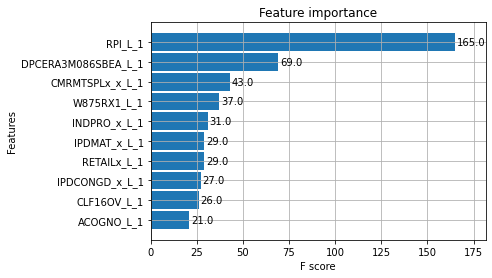

In [27]:
_ = plot_importance(reg, height=0.9,max_num_features=10)


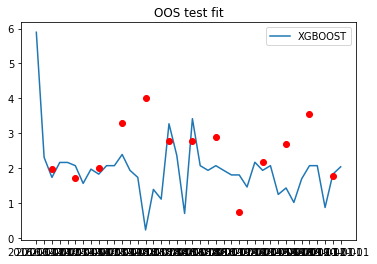

In [31]:
df_test['Prediction'] = reg.predict(X_test)

plt.figure()
#plt.plot(y_test,label="actual")
plt.plot(df_test['Prediction'],label="XGBOOST")
plt.legend()
plt.title('OOS test fit')
plt.plot(df_test['GDPC1'], 'ro')

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test[''],
                   y_pred=df_test['Prediction'])

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import math 
glob_list = list(df.columns.values)
reglist = list()

df_reg = df.copy()
target = 'GDPC1_continuous'

for f in glob_list:
    for i in range(1,2):
        varname = f'{f}_L_{i}'
        reglist.append(varname)
        #df_reg[varname] = df_reg[f].shift(i) 
        df_reg[varname] = df_reg[f].shift(i) 


df_model = df_reg.loc['1980-1-1':'2016-1-1']

x = df_model[reglist]
y = df_model[target]
#print(reglist)

'''XGBOOST BEGINS HERE'''
regressor = xgb.XGBRegressor(
    n_estimators=50,
    reg_lambda=1,
    gamma=0,
    max_depth=5
)
regressor.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

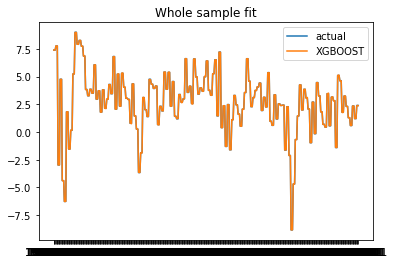

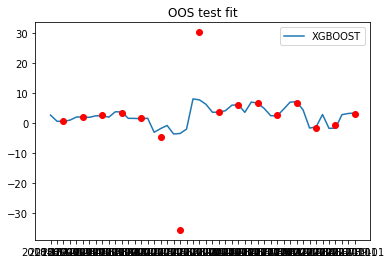

In [8]:
xgpred = regressor.predict(x)
xg_df = pd.DataFrame(xgpred, columns = ['xgfit'], index = df_model.index)

plt.plot(y,label="actual")
plt.plot(xg_df['xgfit'],label="XGBOOST")
plt.legend()
plt.title('Whole sample fit')

df_test = df_reg.loc['2018-1-1':'2022-1-1']
y_test = df_test[target]
x_test = df_test[reglist]

xgpred_test = regressor.predict(x_test)
xg_df_test = pd.DataFrame(xgpred_test, columns = ['xgfit'], index = df_test.index)

plt.figure()
#plt.plot(y_test,label="actual")
plt.plot(xg_df_test,label="XGBOOST")
plt.legend()
plt.title('OOS test fit')
plt.plot(df_test['GDPC1'], 'ro')

In [9]:
#df.to_csv('tester.csv')